In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
print ("hello")

### Reference: https://github.com/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb
###  https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/

In [5]:
import pandas as pd

df = pd.read_csv("/kaggle/input/spamdata/spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.shape

(5572, 2)

In [7]:
!pip install -q transformers

In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [9]:
# check class distribution
df['label'].value_counts(normalize = True)

label
0    0.865937
1    0.134063
Name: proportion, dtype: float64

In [10]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [11]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

2025-08-31 20:20:45.025755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756671645.385476      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756671645.488594      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [13]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


<Axes: >

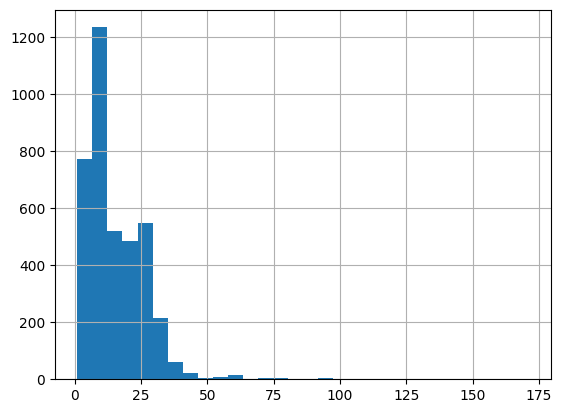

In [14]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [15]:
max_seq_len = 25

In [16]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    # pad_to_max_length=True,
     padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    # pad_to_max_length=True,
     padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    # pad_to_max_length=True,
     padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

### Convert integer seq to tokens

In [17]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

## create data loaders

In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

### Freeze BERT parameters

In [19]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

### Define Model architecture

In [40]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      # _, cls_hs = self.bert(sent_id, attention_mask=mask)
      outputs = self.bert(sent_id, attention_mask=mask)
      cls_hs = outputs.pooler_output
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [41]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [42]:
# optimizer from hugging face transformers
import torch.optim as optim

# define the optimizer
optimizer = optim.AdamW(model.parameters(), lr = 1e-3)

### Find class weights

In [43]:
from sklearn.utils.class_weight import compute_class_weight


#compute the class weights
# class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)
#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes= np.unique(train_labels), y=train_labels)

print(class_wts)

[0.57743559 3.72848948]


In [44]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

### Fine Tune BERT

In [45]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

## Evaluate

In [46]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

### Start model training

In [47]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.523
Validation Loss: 0.308

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.319
Validation Loss: 0.244

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.262
Validation Loss: 0.260

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.253
Validation Loss: 0.346

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.267
Validation Loss: 0.156

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.244
Validation Loss: 0.765

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.238
Validation Loss: 0.179

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.223
Validat

## load saved model

In [48]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

### Get predictions

In [49]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [50]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       724
           1       0.73      0.96      0.83       112

    accuracy                           0.95       836
   macro avg       0.86      0.96      0.90       836
weighted avg       0.96      0.95      0.95       836



In [51]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,685,39
1,4,108


### Using Transformer Library

## Reference: https://towardsdatascience.com/fine-tune-smaller-transformer-models-text-classification-77cbbd3bf02b/

In [1]:
from datasets import load_dataset, DatasetDict

dataset = load_dataset("ilsilfverskiold/clickbait_titles_synthetic_data")
dataset

README.md:   0%|          | 0.00/560 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/337k [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/20.3k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/42.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6614 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/350 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', '__index_level_0__'],
        num_rows: 6614
    })
    validation: Dataset({
        features: ['label', 'text', '__index_level_0__'],
        num_rows: 350
    })
    test: Dataset({
        features: ['label', 'text', '__index_level_0__'],
        num_rows: 818
    })
})

In [2]:
model_name = "albert/albert-base-v2"
your_path = "classify-clickbait"

In [3]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit(dataset['train']['label'])

def encode_labels(example):
    return {'encoded_label': label_encoder.transform([example['label']])[0]}

for split in dataset:
    dataset[split] = dataset[split].map(encode_labels, batched=False)

Map:   0%|          | 0/6614 [00:00<?, ? examples/s]

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [4]:
from transformers import AutoConfig

unique_labels = sorted(list(set(dataset['train']['label'])))
id2label = {i: label for i, label in enumerate(unique_labels)}
label2id = {label: i for i, label in enumerate(unique_labels)}

config = AutoConfig.from_pretrained(model_name)
config.id2label = id2label
config.label2id = label2id

# Verify the correct labels
print("ID to Label Mapping:", config.id2label)
print("Label to ID Mapping:", config.label2id)

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

ID to Label Mapping: {0: 'Clickbait', 1: 'Factual'}
Label to ID Mapping: {'Clickbait': 0, 'Factual': 1}


In [6]:
import torch
# specify GPU
device = torch.device("cuda")

In [7]:
from transformers import AlbertForSequenceClassification, AlbertTokenizer

tokenizer = AlbertTokenizer.from_pretrained(model_name)
model = AlbertForSequenceClassification.from_pretrained(model_name, config=config)
# specify GPU
# model = model.to_device(device)

2025-08-31 21:53:32.759749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756677213.000427      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756677213.067083      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert/albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AttributeError: 'AlbertForSequenceClassification' object has no attribute 'to_device'

In [8]:
def filter_invalid_content(example):
    return isinstance(example['text'], str)

dataset = dataset.filter(filter_invalid_content, batched=False)

def encode_data(batch):
    tokenized_inputs = tokenizer(batch["text"], padding=True, truncation=True, max_length=256)
    tokenized_inputs["labels"] = batch["encoded_label"]
    return tokenized_inputs

dataset_encoded = dataset.map(encode_data, batched=True)
dataset_encoded

Filter:   0%|          | 0/6614 [00:00<?, ? examples/s]

Filter:   0%|          | 0/350 [00:00<?, ? examples/s]

Filter:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/6614 [00:00<?, ? examples/s]

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', '__index_level_0__', 'encoded_label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 6614
    })
    validation: Dataset({
        features: ['label', 'text', '__index_level_0__', 'encoded_label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 350
    })
    test: Dataset({
        features: ['label', 'text', '__index_level_0__', 'encoded_label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [9]:

dataset_encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


In [10]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer)

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

label_encoder = LabelEncoder()
label_encoder.fit(unique_labels)

def per_label_accuracy(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    correct_predictions = cm.diagonal()
    label_totals = cm.sum(axis=1)
    per_label_acc = np.divide(correct_predictions, label_totals, out=np.zeros_like(correct_predictions, dtype=float), where=label_totals != 0)
    return dict(zip(labels, per_label_acc))

In [12]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    decoded_labels = label_encoder.inverse_transform(labels)
    decoded_preds = label_encoder.inverse_transform(preds)

    precision = precision_score(decoded_labels, decoded_preds, average='weighted')
    recall = recall_score(decoded_labels, decoded_preds, average='weighted')
    f1 = f1_score(decoded_labels, decoded_preds, average='weighted')
    acc = accuracy_score(decoded_labels, decoded_preds)

    labels_list = list(label_encoder.classes_)
    per_label_acc = per_label_accuracy(decoded_labels, decoded_preds, labels_list)

    per_label_acc_metrics = {}
    for label, accuracy in per_label_acc.items():
        label_key = f"accuracy_label_{label}"
        per_label_acc_metrics[label_key] = accuracy

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        **per_label_acc_metrics
    }

In [13]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir=your_path,
    num_train_epochs=1,
    warmup_steps=500,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_steps=10,
    # evaluation_strategy='steps',
    eval_steps=100,
    learning_rate=2e-5,
    save_steps=1000,
    gradient_accumulation_steps=2
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_encoded['train'],
    eval_dataset=dataset_encoded['test'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

/tmp/ipykernel_36/1495708527.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

In [ ]:
trainer.evaluate()
trainer.save_model(your_path)
trainer.save_state()

In [ ]:
from transformers import pipeline
pipe = pipeline('text-classification', model=your_path)

In [ ]:
example_titles = [
    "grab an example title",
    "grab another example title",
    "and another xample title"
]

for title in example_titles:
    result = pipe(title)
    print(f"Title: {title}")
    print(f"Output: {result[0]['label']}")

## ref: https://www.kaggle.com/code/neerajmohan/fine-tuning-bert-for-text-classification
